## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices
* slide inference

In [1]:

import importlib.util
import os
import pickle
import sys
import time
from pathlib import Path

import pandas as pd
import torch.nn as nn
from torch.optim import AdamW
from tqdm.auto import tqdm

In [2]:
import socket

exp_id = "Unet_2.5d_exp06"
HOST = socket.gethostname()
date_time = time.strftime("%Y%m%d_%H%M%S")
run_id = exp_id + "_" + date_time


In [3]:
# noinspection PyUnresolvedReferences
is_kaggle = _dh == ["/kaggle/working"]
is_train = True
is_test = True

exp_id, HOST, is_kaggle

('Unet_2.5d_exp06', 'Vincit', False)

In [4]:
if not is_kaggle:
    ROOT_DIR = Path("../").absolute()
    DATA_DIR = ROOT_DIR / "data" / "raw"
    OUTPUT_DIR = ROOT_DIR / "saved"
    CP_DIR = OUTPUT_DIR / "checkpoints"
    LOG_DIR = ROOT_DIR / "saved" / "logs"
    CACHE_DIR = ROOT_DIR / "saved" / "cache"
    EXTERNAL_MODELS_DIR = ROOT_DIR / "model"
else:
    ROOT_DIR = Path("/kaggle")
    DATA_DIR = ROOT_DIR / "input" / "vesuvius-challenge-ink-detection"
    OUTPUT_DIR = ROOT_DIR / "working"
    CP_DIR = OUTPUT_DIR / "ink-model"
    LOG_DIR = OUTPUT_DIR / "saved" / "logs"
    CACHE_DIR = OUTPUT_DIR / "saved" / "cache"
    EXTERNAL_MODELS_DIR = ROOT_DIR / "input"

print(f"ROOT_DIR: {ROOT_DIR}")

for p in [ROOT_DIR, DATA_DIR, OUTPUT_DIR, CP_DIR, LOG_DIR, CACHE_DIR]:
    if os.path.exists(p) is False:
        os.makedirs(p)

if not is_kaggle:
    from logzero import logger
    import logzero

    logzero.logfile(LOG_DIR / f"{exp_id}.log", maxBytes=1e8, backupCount=3)
    logger.info(f"NB: {exp_id}")


def to_pickle(filename, obj):
    with open(filename, mode="wb") as f:
        pickle.dump(obj, f)


def unpickle(filename):
    with open(filename, mode="rb") as fo:
        _ = pickle.load(fo)
    return _

[I 230418 12:44:42 3293208973:29] NB: Unet_2.5d_exp06


ROOT_DIR: D:\Codes\python\kaggle\Vesuvius\dev\..


In [5]:
if is_test:
    # from tqdm import tqdm
    for i in tqdm(range(100)):
        pass

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

if not is_kaggle or True:
    # https://github.com/Cadene/pretrained-models.pytorch/issues/222
    import ssl

    ssl._create_default_https_context = ssl._create_unverified_context
if is_kaggle:
    sys.path.append(str(EXTERNAL_MODELS_DIR / "segmentation_models.pytorch-master"))
    sys.path.append(str(EXTERNAL_MODELS_DIR / "pretrainedmodels-0.7.4"))
    sys.path.append(str(EXTERNAL_MODELS_DIR / "EfficientNet-PyTorch-master"))

    # noinspection PyUnresolvedReferences
    import segmentation_models_pytorch as smp

else:
    if importlib.util.find_spec("segmentation_models_pytorch") is None:
        !conda install -y segmentation-models-pytorch
    import segmentation_models_pytorch as smp
    # %%conda install -y -c conda-forge segmentation-models-pytorch



In [7]:

from torch.utils.data import DataLoader, Dataset
import cv2
import torch


## config

In [8]:
class Config:
    comp_name = "vesuvius"
    # ============== path =============
    comp_dataset_path = DATA_DIR  # dataset path
    cache_dir = CACHE_DIR  # cache directory
    data_dir = DATA_DIR  # data directory
    LOG_DIR = LOG_DIR  # log directory
    Note_book = exp_id  # notebook name
    model_dir = CP_DIR  # model directory
    exp_name = exp_id  # experiment name
    run_id = run_id  # run id
    HOST = HOST  # host name

    # ============== pred target =============
    target_size = 1  # prediction target size

    # ============== model cfg =============
    model_name = "Unet"  # model name
    backbone = "se_resnext50_32x4d"  # model backbone
    in_channels = 6  # number of input channels
    resume = True # resume training

    # ============== training cfg =============
    size = 224  # image size
    tile_size = 224  # tile size
    stride = 56  # tile stride

    batch_size = 48  # batch size
    use_amp = True  # use automatic mixed precision

    scheduler = "GradualWarmupSchedulerV2"  # learning rate scheduler
    epochs = 4  # number of training epochs
    PATIENCE = 7  # early stopping patience
    warmup_factor = 10  # warmup factor
    lr = 1e-5 / 10  # initial learning rate

    # ============== fold =============
    valid_id = 2  # validation fold id

    objective_cv = "binary"  # objective type
    metric_direction = "maximize"  # metric direction

    # ============== fixed =============
    pretrained = True  # use pre-trained weights
    inf_weight = "best"  # inference weight

    min_lr = 1e-6  # minimum learning rate
    weight_decay = 1e-6  # weight decay
    max_grad_norm = 1000  # maximum gradient norm

    print_freq = 50  # print frequency
    num_workers = 2  # number of workers
    seed = 3407  # random seed

    def __getitem__(self, item):
        return getattr(self, item)


_Config = Config()




In [9]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

CONFIG = {}
for k in dir(_Config):
    if not k.startswith("__"):
        CONFIG[k] = getattr(_Config, k)

for k in CONFIG.keys():
    if k not in CONFIG.keys():
        print(f"{k} is not in CONFIG")
    elif CONFIG[k] != CONFIG[k]:
        print(f"CONFIG {k} = {CONFIG[k]};is not equal to tmp {k} = {CONFIG[k]}")
    else:
        continue

for k in CONFIG.keys():
    if k not in CONFIG.keys():
        print(f"{k} is not in Config")
    else:
        continue

In [10]:
cfg=CONFIG

In [11]:


# ============== augmentation =============
def get_aug_list(size, in_channels, type='train'):
    """
    type: train, valid
    return: list of albumentations

    in case of any further modification,
    one should use albu.Compose by themselves
    """
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        albu.Resize(size, size),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.75),
        albu.ShiftScaleRotate(p=0.75),
        albu.OneOf([
            albu.GaussNoise(var_limit=[10, 50]),
            albu.GaussianBlur(),
            albu.MotionBlur(),
        ], p=0.4),
        albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        albu.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                           mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        albu.Resize(size, size),
        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels
        ),
        ToTensorV2(transpose_mask=True),
    ]

    if type == 'train':
        return train_aug_list
    else:
        return valid_aug_list




In [12]:
%%capture
# disable output of this cell
if not (is_kaggle or is_test):
    import wandb

    wandb.init(project=cfg['comp_name'], name=cfg['run_id'],
               config=CONFIG, dir=LOG_DIR / "wandb")

    wandb.cfg['train_aug_list'] = albu.Compose(
        get_aug_list(cfg['size'], cfg['in_channels'], type='train')).to_dict()
    wandb.cfg['valid_aug_list'] = albu.Compose(
        get_aug_list(cfg['size'], cfg['in_channels'], type='valid')).to_dict()

In [13]:
import importlib.util


class AverageMeter(object):
    """Computes and stores the average and current value"""

    # if imported wandb, use wandb.log
    #

    def __init__(self, mode="train"):
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None
        self.mode = mode

        self.reset()
        self.use_wandb = (importlib.util.find_spec('wandb') is not None)

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
IS_DEBUG = True
mode = 'train' if IS_DEBUG else 'test'
TH = 0.4

## helper

In [15]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# def np_rle(img):
#     flat_img = np.where(img.flatten() , 1, 0).astype(np.uint8)
#     starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
#     ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
#     starts_ix = np.where(starts)[0] + 2
#     ends_ix = np.where(ends)[0] + 2
#     lengths = ends_ix - starts_ix
#     predicted_arr = np.stack([starts_ix, lengths]).T.flatten()
#     rle_str=np.array2string(predicted_arr.reshape(-1), separator=' ')
#     return rle_str[1:-1]

In [16]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler



    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))

    # remove existing handlers
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

In [17]:
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=str(cfg['LOG_DIR'] / cfg['run_id']) + '.log')

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


In [18]:
# img=cv2.imread(str(cfg['comp_dataset_path']/ f"/{mode}/1/mask.png"), 0)
# str1=rle(img)
# str2=np_rle(img)
# import cProfile
# cProfile.run('')
# cProfile.run('str2=np_rle(img)')

# assert str1 == str2


## dataset

In [19]:
# def read_image(fragment_id):
#     images = []
#
#     # idxs = range(65)
#     mid = 65 // 2
#     start = mid - cfg['in_channels'] // 2
#     end = mid + cfg['in_channels'] // 2
#     idxs = range(start, end)
#     logger.info(f"reading image fragment_id: {fragment_id}, idxs: {idxs}")
#
#     with tqdm(idxs) as pbar:
#         for i in pbar:
#             image = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/surface_volume/{i:02}.tif"), 0)
#
#             pad0 = (cfg['tile_size'] - image.shape[0] % cfg['tile_size'])
#             pad1 = (cfg['tile_size'] - image.shape[1] % cfg['tile_size'])
#
#             image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
#
#             images.append(image)
#     images = np.stack(images, axis=2)
#
#     return images

In [20]:
def get_transforms(mode, cfg):
    return albu.Compose(get_aug_list(cfg['size'], cfg['in_channels'], type=mode))


if not is_kaggle:
    from DataSets import CustomDataset
else:

    from cachetools import FIFOCache, cached


    class ImgLoader:

        def __init__(self, cache_dir: Path = None, data_dir: Path = None):
            self.cache_dir = cache_dir
            self.data_dir = data_dir

        def load_from_path(self, file_path: str = None, channel=6):
            return ImgLoader.load_from_path_static(self.cache_dir, self.data_dir, file_path, channel=channel)

        @staticmethod
        @cached(cache=FIFOCache(maxsize=10))
        def load_from_path_static(cache_dir: Path = None, data_dir: Path = None, file_path: str = None, channel=6):
            if isinstance(file_path, Path):
                file_path = str(file_path)

            assert not file_path.endswith('npy'), f"file path {file_path} is a npy file"
            assert os.path.exists(data_dir / file_path), f"file path {file_path} does not exist"

            path__npy_ = cache_dir / f"{file_path}.npy"

            if os.path.exists(path__npy_):
                img_l = np.load(str(path__npy_), allow_pickle=True)
                assert img_l is not None, f"Cached file {path__npy_} is None"
                return img_l

            if not os.path.exists(path__npy_.parent):
                os.makedirs(path__npy_.parent)

            if os.path.isfile(data_dir / file_path):
                img_l = cv2.imread(str(data_dir / file_path), 0)
                assert img_l is not None, f"Image file {data_dir / file_path} is None"
                np.save(str(path__npy_), img_l)
                return img_l

            if os.path.isdir(data_dir / file_path):
                path__npy_ = cache_dir / f"{file_path}_{channel}.npy"
                if os.path.exists(path__npy_):
                    img_l = np.load(str(path__npy_), allow_pickle=True)
                    assert img_l is not None, f"Cached file {path__npy_} is None"
                    return img_l

                img_l = []
                files = os.listdir(data_dir / file_path)
                mid = len(files) // 2
                start = mid - channel // 2
                end = mid + channel // 2
                assert start >= 0, f"start {start} is less than 0"
                assert end <= len(files), f"end {end} is greater than {len(files)}"

                files = files[start:end]
                for file in tqdm(files):
                    img_l.append(ImgLoader.load_from_path_static(cache_dir, data_dir, f"{file_path}/{file}"))

                img_l = np.stack(img_l, axis=2)
                np.save(str(path__npy_), img_l)
                return img_l


    class CustomDataset(Dataset):
        """"
        Custom Dataset for loading images, masks, and labels
        params:
            image_sets: list of image paths
            masks: list of mask paths
            labels: list of label paths
            transform: albumentations transform
            mode: train, valid, or test
        """

        def __init__(self, image_sets, cfg, masks=None, labels=None, transform=None, mode="train"):
            self.image_sets = image_sets
            self.cfg = cfg
            self.masks = masks
            self.labels = labels
            self.transform = transform
            self.type = mode
            self.imgLoader = None
            self.patch_num = []
            self.preprocess()

        def preprocess(self):
            if self.imgLoader is None:
                self.imgLoader = ImgLoader(
                    cache_dir=self.cfg['cache_dir'],
                    data_dir=self.cfg['data_dir'])

            for mask in self.masks:
                # mask may be path like or numpy array
                if isinstance(mask, (str, Path)):
                    mask = self.imgLoader.load_from_path(mask)

                x1_num = math.ceil((mask.shape[1] - self.cfg['tile_size']) / self.cfg['stride']) + 1
                y1_num = math.ceil((mask.shape[0] - self.cfg['tile_size']) / self.cfg['stride']) + 1

                self.patch_num.append((x1_num, y1_num))

            self.patch_num = np.array(self.patch_num)

        def get_gt(self, img_idx):
            return self.imgLoader.load_from_path(self.labels[img_idx])

        def get_mask(self, img_idx):
            return self.imgLoader.load_from_path(self.masks[img_idx])

        def __len__(self):
            x, y = np.transpose(self.patch_num)
            return x @ y

        def __getitem__(self, idx):
            # x1, y1, x2, y2 = self.xyxys[idx]
            img_id = 0
            patch_id = idx
            for i, patch_num in enumerate(self.patch_num):
                if patch_id < patch_num[0] * patch_num[1]:
                    img_id = i
                    break
                else:
                    patch_id -= patch_num[0] * patch_num[1]

            x1_num, y1_num = self.patch_num[img_id]
            x1 = (patch_id % x1_num) * self.cfg['stride']
            y1 = (patch_id // x1_num) * self.cfg['stride']
            x2 = x1 + self.cfg['tile_size']
            y2 = y1 + self.cfg['tile_size']

            img = self.imgLoader.load_from_path(self.image_sets[img_id], channel=self.cfg['in_channels'])
            mask = self.imgLoader.load_from_path(self.masks[img_id])
            label = self.imgLoader.load_from_path(self.labels[img_id])

            img = img[y1:y2, x1:x2]
            mask = mask[y1:y2, x1:x2]

            if img.shape[0] != self.cfg['tile_size'] or img.shape[1] != self.cfg['tile_size']:
                pad_h = self.cfg['tile_size'] - img.shape[0]
                pad_w = self.cfg['tile_size'] - img.shape[1]
                img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode="constant", constant_values=0)
                mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

            if self.type in ["train", "valid"]:
                label = label[y1:y2, x1:x2]
                if label.shape[0] != self.cfg['tile_size'] or label.shape[1] != self.cfg['tile_size']:
                    pad_h = self.cfg['tile_size'] - label.shape[0]
                    pad_w = self.cfg['tile_size'] - label.shape[1]
                    label = np.pad(label, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

                data = self.transform(image=img, mask=mask, label=label)
                label = data["label"].astype(np.float32)
            else:
                label = None
                data = self.transform(image=img, mask=mask)

            # if mask != data["mask"]:
            #     print("mask is not equal")`
            #     fig, ax = plt.subplots(1, 2)
            #     ax[0].imshow(mask)
            #     ax[1].imshow(data["mask"])
            #     ax[0].set_title("mask")
            #     ax[1].set_title("data[mask]")
            #     plt.show()
            image = data["image"]
            mask = data["mask"]

            return image, mask, label, (x1, y1, x2, y2)

            # image = self.image_sets[idx]
            # data = self.transform(image=image)
            # image = data['image']
            # return image


In [21]:
def make_dataset(img_set_ids, dataset_mode='train'):
    imgs = []
    masks = []
    labels = []
    for set_id in img_set_ids:
        imgs.append(f"{mode}/{set_id}/surface_volume")
        masks.append(f"{mode}/{set_id}/mask.png")
        labels.append(f"{mode}/{set_id}/inklabels.png")

    # test_images = read_image(fragment_id)
    #
    # x1_list = list(range(0, test_images.shape[1] - cfg['tile_size']+ 1, cfg['stride']))
    # y1_list = list(range(0, test_images.shape[0] - cfg['tile_size']+ 1, cfg['stride']))
    #
    # test_images_list = []
    # xyxys = []
    # for y1 in y1_list:
    #     for x1 in x1_list:
    #         y2 = y1 + cfg['tile_size']
    #         x2 = x1 + cfg['tile_size']
    #         test_images_list.append(test_images[y1:y2, x1:x2])
    #         xyxys.append((x1, y1, x2, y2))
    # xyxys = np.stack(xyxys)

    dataset = CustomDataset(
        image_sets=imgs,
        cfg=cfg,
        masks=masks,
        labels=labels,
        mode=dataset_mode,
        transform=get_transforms(mode=dataset_mode, cfg=cfg))

    loader = DataLoader(
        dataset,
        batch_size=cfg['batch_size'],
        shuffle=False,
        num_workers=cfg['num_workers'],
        pin_memory=True,
        drop_last=False)

    return loader

In [22]:
# def make_dataset(img_set_id, mode='train',data_set='train'):
#
#     imgs_path= cfg['comp_dataset_path']/ f"{data_set}/{img_set_id}/surface_volume"

In [23]:
if is_test:
    import numpy as np

    x = range(1, 4)
    y = range(1, 4)
    import itertools as it

    k = list(it.product(x, y))
    a = np.sum([x * y for x, y in k])
    print(k)
    print(a)

    x, y = np.transpose(k)
    print(x, y)
    print(x @ y)

# test_image = read_image(3)
# test_image.shape
# x1_list = list(range(0, test_image.shape[1] - cfg['tile_size'] + 1, cfg['stride']))
# assert len(x1_list) == math.ceil((test_image.shape[1] - cfg['tile_size'] + 1) / cfg['stride'])
# math.ceil((test_image.shape[1] - cfg['tile_size'])/ cfg['stride'])+1

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
36
[1 1 1 2 2 2 3 3 3] [1 2 3 1 2 3 1 2 3]
36


## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg['backbone'],
            encoder_weights=weight,
            in_channels=cfg['in_channels'],
            classes=cfg['target_size'],
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def get_saved_model_path(cfg, fold=1):
    return str(cfg['model_dir']) + f'{cfg["model_name"]}_fold{fold}_best.pth'


def get_model_path(cfg, fold=1):
    """
    return saved model path if exists, otherwise return external model path
    """
    if os.path.exists(get_saved_model_path(cfg, fold)):
        return get_saved_model_path(cfg, fold)
    else:
        _tmp = str(EXTERNAL_MODELS_DIR / f"{cfg['exp_name']}/vesuvius-models/Unet_fold{fold}_best.pth'")
        Logger.info(f'trained model not found \n'
                    f'load model from {_tmp}')
    return _tmp


def build_model(cfg, weight="imagenet",fold=1):
    Logger.info(f"model_name: {cfg['model_name']}")
    Logger.info(f"backbone: {cfg['backbone']}")
    if not cfg['resume']:
        _model = CustomModel(cfg, weight)
        return _model

    model_path = get_model_path(cfg, fold)
    Logger.info(f'load model from: {model_path}')
    if os.path.exists(model_path):
        _model = CustomModel(cfg, weight=None)
        _model.load_state_dict(torch.load(model_path)['model'])
        return _model
    else:
        _model = CustomModel(cfg, weight)
        return _model




In [25]:
class EnsembleModel:
    def __init__(self, use_tta=False):
        self.models = []
        self.use_tta = use_tta

    def __call__(self, x):
        outputs = [torch.sigmoid(model(x)).to('cpu').numpy()
                   for model in self.models]
        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def build_ensemble_model():
    # if mode == 'test'
    #  load from saved model
    _model = EnsembleModel()
    for _fold in [1, 2, 3]:
        model = build_model(cfg, weight=None,fold=_fold)
        model.to(device)

        # model_path = get_model_path(CONFIG, fold=_fold)
        # state = torch.load(model_path)['model']
        # model.load_state_dict(state)
        model.eval()

        _model.add_model(model)

    return _model

In [26]:
if mode == 'test':
    fragment_ids = sorted(os.listdir(cfg['comp_dataset_path'] / mode))
else:
    fragment_ids = [3]

In [27]:
# def score(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#
#     # use F0.5 score
#     B = 0.5
#     B2 = B * B
#     TruePositive = np.sum(y_true * y_pred)
#     FalsePositive = np.sum((1 - y_true) * y_pred)
#     FalseNegative = np.sum(y_true * (1 - y_pred))
#     p = TruePositive / (TruePositive + FalsePositive + 1e-6)
#     r = TruePositive / (TruePositive + FalseNegative + 1e-6)
#     score = (1 + B2) * p * r / (B2 * p + r + 1e-6)
#     return score

In [28]:
# model = build_ensemble_model()

## Scheduler

In [29]:

import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingLR


# from warmup_scheduler import GradualWarmupScheduler


# class GradualWarmupSchedulerV2(GradualWarmupScheduler):
#     """
#     https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
#     """
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
#         super(GradualWarmupSchedulerV2, self).__init__(
#             optimizer, multiplier, total_epoch, after_scheduler)
#
#     def get_lr(self):
#         if self.last_epoch > self.total_epoch:
#             if self.after_scheduler:
#                 if not self.finished:
#                     self.after_scheduler.base_lrs = [
#                         base_lr * self.multiplier for base_lr in self.base_lrs]
#                     self.finished = True
#                 return self.after_scheduler.get_lr()
#             return [base_lr * self.multiplier for base_lr in self.base_lrs]
#         if self.multiplier == 1.0:
#             return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
#         else:
#             return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = CosineAnnealingLR(
        optimizer, cfg["epochs"], eta_min=1e-7)
    # scheduler = GradualWarmupSchedulerV2(
    #     optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler_cosine


def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)

## Metrics

In [30]:


def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets == 1].sum()
    cfp = preds[targets == 0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice


def calc_fbeta(mask, mask_pred):
    assert mask.shape == mask_pred.shape, f'mask.shape:{mask.shape} != mask_pred.shape:{mask_pred.shape}'
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    # for th in np.array(range(10, 50 + 1, 5)) / 100:
    for th in np.linspace(10, 51, 5) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        Logger.info(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th

    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## Loss

In [31]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)


def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train and valid

In [32]:
if is_test:
    pass
# test_loader, xyxys = make_test_dataset(3)
# len(test_loader)

In [33]:
from torch.cuda.amp import autocast, GradScaler


def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CONFIG["use_amp"])
    losses = AverageMeter()

    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for step, data in pbar:
            images, masks, labels, positions = data

            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with autocast(CONFIG["use_amp"]):
                y_preds = model(images).squeeze()

                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), CONFIG["max_grad_norm"])

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    return losses.avg


def valid_fn(valid_loader, model, criterion, device, valid_mask_gt):
    label_pred = np.zeros(valid_mask_gt.shape)
    label_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter(mode='valid')

    with tqdm(enumerate(valid_loader), total=len(valid_loader)) as pbar:
        for step, (images, masks, labels, positions) in pbar:


            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with torch.no_grad():
                y_preds = model(images).squeeze()
                loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)

            # make whole mask
            y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
            # start_idx = step*CONFIG["valid_batch_size"]             # end_idx = start_idx + batch_size
            # print(positions)
            for i, (x1, y1, x2, y2) in enumerate(zip(*positions)):
                label_pred[y1:y2, x1:x2] += y_preds[i]
                label_count[y1:y2, x1:x2] += np.ones((y2 - y1, x2 - x1))

    Logger.info(f'mask_count_min: {label_count.min()}')
    label_pred /= label_count+1e-8
    return losses.avg, label_pred

In [34]:
# TODO
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=""):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            logger.info(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )

        # if os.path.exists(CP_DIR / f'checkpoint_{NB}_{fold}.pt'):
        #    shutil.move(CP_DIR / f'checkpoint_{NB}_{fold}.pt', CP_DIR / f'checkpoint_{NB}_{fold}-2.pt')
        torch.save(model.state_dict(),"TODO")
        self.val_loss_min = val_loss

In [35]:
pass
# results = []
# for fragment_id in fragment_ids:

# def test(fragment_id):
#     model= build_ensemble_model()
#     test_loader = make_dataset(fragment_id, dataset_mode='test')
#
#     # binary_mask = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/mask.png"), 0)
#     binary_mask = test_loader.dataset.imgLoader.load_from_path(test_loader.dataset.masks[0])
#     binary_mask = (binary_mask / 255).astype(int)
#
#     ori_h = binary_mask.shape[0]
#     ori_w = binary_mask.shape[1]
#     # mask = mask / 255
#
#     pad0 = (cfg['tile_size'] - binary_mask.shape[0] % cfg['tile_size'])
#     pad1 = (cfg['tile_size'] - binary_mask.shape[1] % cfg['tile_size'])
#
#     Logger.info("trunk test")
#     binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
#
#     mask_pred = np.zeros(binary_mask.shape)
#     mask_count = np.zeros(binary_mask.shape)
#     with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
#         for step, (image,mask,label,pos) in pbar:
#             # for step, (images) in tqdm(enumerate(test_loader)):
#             # MEMO The image wil be a list in size of batch size
#             images = images.to(device)
#             batch_size = images.size(0)
#
#             with torch.no_grad():
#                 y_preds = model(images)
#
#             # start_idx = step * cfg['batch_size']
#             # end_idx = start_idx + batch_size
#             for (x1, y1, x2, y2), y_pred in zip(pos, y_preds):
#                 mask_pred[y1:y2, x1:x2] += y_pred.squeeze(0)
#                 mask_count[y1:y2, x1:x2] += np.ones((cfg['tile_size'], cfg['tile_size']))
#             # for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
#             #     mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
#             #     mask_count[y1:y2, x1:x2] += np.ones((cfg['tile_size'], cfg['tile_size']))
#
#     if is_test:
#         plt.imshow(mask_count)
#         plt.show()
#
#     Logger.info(f'mask_count_min: {mask_count.min()}')
#     mask_pred /= mask_count
#
#     mask_pred = mask_pred[:ori_h, :ori_w]
#     binary_mask = binary_mask[:ori_h, :ori_w]
#
#     mask_pred = (mask_pred >= TH).astype(int)
#     mask_pred *= binary_mask
#
#     inklabels_rle = rle(mask_pred)
#
#     results.append((fragment_id, inklabels_rle))
#     label_true = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/inklabels.png"), 0)
#
#     fig, ax = plt.subplots(1, 2, figsize=(20, 20))
#     ax[0].imshow(mask_pred)
#     ax[0].title.set_text('pred')
#     ax[1].imshow(label_true)
#     ax[1].title.set_text('true')
#     F05 = score(mask_pred, label_true)
#     Logger.info('score', F05)
#     # plt.show()
#     # wandb.run.summary(f"score_{fragment_id}", F05)
#     wandb.log({"test_score": F05})
#     wandb.log({"test_img": [wandb.Image(fig, caption=f"score_{fragment_id}")]})
#
#     del mask_pred, mask_count
#     del test_loader
#
#     gc.collect()
#     torch.cuda.empty_cache()


In [36]:
# if is_test:
#     Logger.info(y_preds[0].shape)
#     str(CONFIG["comp_dataset_path"] / f"{mode}/{fragment_id}/inklabel.png")
pass

In [37]:
# CFG = CONFIG
# wandb.log({"test_score": F05})
# wandb.log({"test_img": [wandb.Image(fig, caption=f"score_{fragment_id}")]})

Logger.info(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2023-04-18 12:44:44


## Main

In [38]:
# if is_test:
# import cProfile
# from time import sleep
# def bench():
#     train_loader = make_dataset([1, 2], dataset_mode='train')
#     train_dataset = train_loader.dataset
#     sample = next(iter(train_dataset))
#     with tqdm(enumerate(train_dataset), total=len(train_dataset)) as pbar:
#         for step, data in pbar:
#             for i in range(3):
#
#                 assert sample[i].shape == data[i].shape, f"in step {step} " \
#                                                          f"sample[{i}].shape: {sample[i].shape} != data[{i}].shape: {data[i].shape}"
#
# cProfile.run('bench()', sort='cumtime')


In [39]:


# foldset = []
# foldset.append({
#     'train': [1, 2],
#     'valid': [3]
# })
# foldset.append({
#     'train': [1, 3],
#     'valid': [2]
# })
# foldset.append({
#     'train': [2, 3],
#     'valid': [1]
# })
# # fold = cfg['valid_id']
# if cfg['metric_direction'] == 'minimize':
#     best_score = np.inf
# elif cfg['metric_direction'] == 'maximize':
#     best_score = -1
# else:
#     best_score = 0
#
# best_lo

In [40]:
pass
# for fold in foldset:
#     train_loader = make_dataset([1, 2], dataset_mode='train')
#     valid_loader = make_dataset([3], dataset_mode='valid')
#     valid_mask_gt = valid_loader.dataset.get_gt(0)
#
#     if valid_mask_gt.max() > 1:
#         Logger.info(f'valid_mask_gt.shape: {valid_mask_gt.shape} \n'
#                     f'valid_mask_gt.max: {valid_mask_gt.max()} \n')
#         valid_mask_gt = valid_mask_gt / 255
#
#     pad0 = (CONFIG["tile_size"] - valid_mask_gt.shape[0] % CONFIG["tile_size"])
#     pad1 = (CONFIG["tile_size"] - valid_mask_gt.shape[1] % CONFIG["tile_size"])
#     valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)
#
#     model = build_model(cfg)
#     model.to(device)
#
#     optimizer = AdamW(model.parameters(), lr=CONFIG["lr"])
#     scheduler = get_scheduler(CONFIG, optimizer)
#
#     for epoch in range(CONFIG["epochs"]):
#
#         start_time = time.time()
#
#         # train
#         avg_loss = train_fn(train_loader, model, criterion, optimizer, device)
#
#         # eval
#         avg_val_loss, mask_pred = valid_fn(
#             valid_loader, model, criterion, device, valid_mask_gt)
#
#         scheduler_step(scheduler, avg_val_loss, epoch)
#
#         best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)
#
#         # score = avg_val_loss
#         score = best_dice
#
#         elapsed = time.time() - start_time
#
#         Logger.info(
#             f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
#         Logger.info(
#             f'Epoch {epoch + 1} - avgScore: {score:.4f}')
#
#         if CONFIG["metric_direction"] == 'minimize':
#             update_best = score < best_score
#         elif CONFIG["metric_direction"] == 'maximize':
#             update_best = score > best_score
#
#         if update_best:
#             best_loss = avg_val_loss
#             best_score = score
#
#             Logger.info(
#                 f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
#             Logger.info(
#                 f'Epoch {epoch + 1} - Save Best Loss: {best_loss:.4f} Model')
#
#             torch.save({'model': model.state_dict(),
#                         'preds': mask_pred},
#                        CONFIG["model_dir"] + f'{CONFIG["model_name"]}_fold{fold}_best.pth')

In [41]:
# import numpy as np
# import time
# from torch.optim import AdamW


def create_foldset():
    foldset = []
    foldset.append({
        'train': [1, 2],
        'valid': [3]
    })
    foldset.append({
        'train': [1, 3],
        'valid': [2]
    })
    foldset.append({
        'train': [2, 3],
        'valid': [1]
    })
    return foldset


def get_best_score(metric_direction):
    if metric_direction == 'minimize':
        return np.inf
    elif metric_direction == 'maximize':
        return -1
    else:
        return 0


def preprocess_valid_mask_gt(valid_mask_gt, tile_size):
    if valid_mask_gt.max() > 1:
        Logger.info(f'valid_mask_gt.shape: {valid_mask_gt.shape} \n'
                    f'valid_mask_gt.max: {valid_mask_gt.max()} \n')
        valid_mask_gt = valid_mask_gt / 255

    pad0 = (tile_size - valid_mask_gt.shape[0] % tile_size)
    pad1 = (tile_size - valid_mask_gt.shape[1] % tile_size)
    valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

    return valid_mask_gt


def should_update_best_score(metric_direction, score, best_score):
    if metric_direction == 'minimize':
        return score < best_score
    elif metric_direction == 'maximize':
        return score > best_score


In [42]:
# fold_configs = create_foldset()
#
# best_score = -1 if CONFIG["metric_direction"] == 'maximize' else np.inf
# best_loss = np.inf
#
# # CONFIG["epochs"] = 4
# model = build_model(cfg,fold=fold_configs[0]["valid"][0])

In [57]:


fold_configs = create_foldset()

best_score = -1 if CONFIG["metric_direction"] == 'maximize' else np.inf
best_loss = np.inf

# CONFIG["epochs"] = 4
# TODO the best score should be compared
# with the best score of the loaded model
# if there's any
Logger.info(CONFIG)

for fold_config in fold_configs:
    train_loader = make_dataset(fold_config["train"], dataset_mode='train')
    valid_loader = make_dataset(fold_config["valid"], dataset_mode='valid')

    Logger.info(f'fold_config: {fold_config}')

    valid_mask_gt = valid_loader.dataset.get_gt(0)

    valid_mask_gt = preprocess_valid_mask_gt(valid_mask_gt, CONFIG["tile_size"])

    model = build_model(cfg,fold=fold_config["valid"][0])
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=CONFIG["lr"])
    scheduler = get_scheduler(CONFIG, optimizer)

    # early_stopping = EarlyStopping(
    #         patience=Config.PATIENCE, verbose=True, fold=fold_config["valid"][0]
    #     )

    for epoch in range(CONFIG["epochs"]):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

        # eval
        avg_val_loss, label_pred = valid_fn(
            valid_loader, model, criterion, device, valid_mask_gt)

        scheduler_step(scheduler, avg_val_loss, epoch)

        best_dice, best_th = calc_cv(valid_mask_gt, label_pred)

        # score = avg_val_loss
        score = best_dice

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        Logger.info(
            f'Epoch {epoch + 1} - avgScore: {score:.4f}')

        if should_update_best_score(CONFIG["metric_direction"], score, best_score):
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch + 1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'best_score': best_score,
                        'best_loss': best_loss,
                        'pred': label_pred},
                       get_saved_model_path(CONFIG, fold_config["valid"][0]))



{'HOST': 'Vincit', 'LOG_DIR': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/logs'), 'Note_book': 'Unet_2.5d_exp06', 'PATIENCE': 7, 'backbone': 'se_resnext50_32x4d', 'batch_size': 48, 'cache_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/cache'), 'comp_dataset_path': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../data/raw'), 'comp_name': 'vesuvius', 'data_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../data/raw'), 'epochs': 4, 'exp_name': 'Unet_2.5d_exp06', 'in_channels': 6, 'inf_weight': 'best', 'lr': 1.0000000000000002e-06, 'max_grad_norm': 1000, 'metric_direction': 'maximize', 'min_lr': 1e-06, 'model_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/checkpoints'), 'model_name': 'Unet', 'num_workers': 2, 'objective_cv': 'binary', 'pretrained': True, 'print_freq': 50, 'resume': True, 'run_id': 'Unet_2.5d_exp06_20230418_124442', 'scheduler': 'GradualWarmupSchedulerV2', 'seed': 3407, 'size': 224, 'stride': 56, 'target_size': 1, 't

  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

mask_count_min: 0.0
C:\Users\lzhen\miniconda3\envs\kaggle_Vesuvius\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
th: 0.1, fbeta: 0.09700670623215245
th: 0.2025, fbeta: 0.131275408212914
th: 0.305, fbeta: 0.14800903797345638
th: 0.4075, fbeta: 0.15171590794375248
th: 0.51, fbeta: 0.15460417201494672
best_th: 0.51, fbeta: 0.15460417201494672
Epoch 1 - avg_train_loss: -43.3322  avg_val_loss: -118.2796  time: 322s
Epoch 1 - avgScore: 0.1546
Epoch 1 - Save Best Score: 0.1546 Model
Epoch 1 - Save Best Loss: -118.2796 Mo

  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.09725834284847502
th: 0.2025, fbeta: 0.13822393048871115
th: 0.305, fbeta: 0.14813511146801567
th: 0.4075, fbeta: 0.1513300303705298
th: 0.51, fbeta: 0.15400190317786802
best_th: 0.51, fbeta: 0.15400190317786802
Epoch 2 - avg_train_loss: -45.7757  avg_val_loss: -170.2134  time: 274s
Epoch 2 - avgScore: 0.1540


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.09728781539257522
th: 0.2025, fbeta: 0.14012531179587812
th: 0.305, fbeta: 0.149185168335929
th: 0.4075, fbeta: 0.15217247369123965
th: 0.51, fbeta: 0.15548188272614913
best_th: 0.51, fbeta: 0.15548188272614913
Epoch 3 - avg_train_loss: -47.5894  avg_val_loss: -136.3482  time: 275s
Epoch 3 - avgScore: 0.1555
Epoch 3 - Save Best Score: 0.1555 Model
Epoch 3 - Save Best Loss: -136.3482 Model


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.09709043871470882
th: 0.2025, fbeta: 0.13685480608139752
th: 0.305, fbeta: 0.14887648392316982
th: 0.4075, fbeta: 0.1519038586779691
th: 0.51, fbeta: 0.15473220566338997
best_th: 0.51, fbeta: 0.15473220566338997
Epoch 4 - avg_train_loss: -48.6345  avg_val_loss: -121.1678  time: 276s
Epoch 4 - avgScore: 0.1547
fold_config: {'train': [1, 3], 'valid': [2]}
valid_mask_gt.shape: (14830, 9506) 
valid_mask_gt.max: 255 

model_name: Unet
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpointsUnet_fold2_best.pth


  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.14529608140316472
th: 0.2025, fbeta: 0.14530383482071368
th: 0.305, fbeta: 0.20079860325456975
th: 0.4075, fbeta: 0.20883420938039593
th: 0.51, fbeta: 0.22347531517171929
best_th: 0.51, fbeta: 0.22347531517171929
Epoch 1 - avg_train_loss: -48.4700  avg_val_loss: -75.8615  time: 217s
Epoch 1 - avgScore: 0.2235
Epoch 1 - Save Best Score: 0.2235 Model
Epoch 1 - Save Best Loss: -75.8615 Model


  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.1452962212022781
th: 0.2025, fbeta: 0.14531134460807418
th: 0.305, fbeta: 0.20229366915959537
th: 0.4075, fbeta: 0.21043479641111132
th: 0.51, fbeta: 0.2271876584857543
best_th: 0.51, fbeta: 0.2271876584857543
Epoch 2 - avg_train_loss: -50.4424  avg_val_loss: -70.4424  time: 269s
Epoch 2 - avgScore: 0.2272
Epoch 2 - Save Best Score: 0.2272 Model
Epoch 2 - Save Best Loss: -70.4424 Model


  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.14529648262115824
th: 0.2025, fbeta: 0.1453473485848836
th: 0.305, fbeta: 0.20242053580420427
th: 0.4075, fbeta: 0.21261259948887992
th: 0.51, fbeta: 0.23612710645150312
best_th: 0.51, fbeta: 0.23612710645150312
Epoch 3 - avg_train_loss: -50.8717  avg_val_loss: -42.9616  time: 308s
Epoch 3 - avgScore: 0.2361
Epoch 3 - Save Best Score: 0.2361 Model
Epoch 3 - Save Best Loss: -42.9616 Model


  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.14529615169900234
th: 0.2025, fbeta: 0.1453361343858921
th: 0.305, fbeta: 0.2030904474261412
th: 0.4075, fbeta: 0.21035877924847154
th: 0.51, fbeta: 0.2327948662796488
best_th: 0.51, fbeta: 0.2327948662796488
Epoch 4 - avg_train_loss: -50.5052  avg_val_loss: -42.2273  time: 227s
Epoch 4 - avgScore: 0.2328
fold_config: {'train': [2, 3], 'valid': [1]}
valid_mask_gt.shape: (8181, 6330) 
valid_mask_gt.max: 255 

model_name: Unet
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpointsUnet_fold1_best.pth


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.12386265578513507
th: 0.2025, fbeta: 0.12773715014349188
th: 0.305, fbeta: 0.21055720993801266
th: 0.4075, fbeta: 0.2214434674550115
th: 0.51, fbeta: 0.2306632143594401
best_th: 0.51, fbeta: 0.2306632143594401
Epoch 1 - avg_train_loss: -43.7893  avg_val_loss: -112.5999  time: 357s
Epoch 1 - avgScore: 0.2307


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.12385409595326426
th: 0.2025, fbeta: 0.14168644093750302
th: 0.305, fbeta: 0.21252174640264138
th: 0.4075, fbeta: 0.22173976603367143
th: 0.51, fbeta: 0.23138515676668553
best_th: 0.51, fbeta: 0.23138515676668553
Epoch 2 - avg_train_loss: -44.8015  avg_val_loss: -109.8383  time: 345s
Epoch 2 - avgScore: 0.2314


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.12411180821171515
th: 0.2025, fbeta: 0.17209290362381122
th: 0.305, fbeta: 0.21454308193451044
th: 0.4075, fbeta: 0.22158343033985575
th: 0.51, fbeta: 0.23012024711150766
best_th: 0.51, fbeta: 0.23012024711150766
Epoch 3 - avg_train_loss: -45.4890  avg_val_loss: -105.4094  time: 370s
Epoch 3 - avgScore: 0.2301


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.12416689846294966
th: 0.2025, fbeta: 0.16973711521512666
th: 0.305, fbeta: 0.2143168333357017
th: 0.4075, fbeta: 0.22156802853530597
th: 0.51, fbeta: 0.2312084409507593
best_th: 0.51, fbeta: 0.2312084409507593
Epoch 4 - avg_train_loss: -46.2963  avg_val_loss: -92.9309  time: 281s
Epoch 4 - avgScore: 0.2312


In [44]:
# avg_val_loss, mask_pred = valid_fn(
#             valid_loader, model, criterion, device, valid_mask_gt)

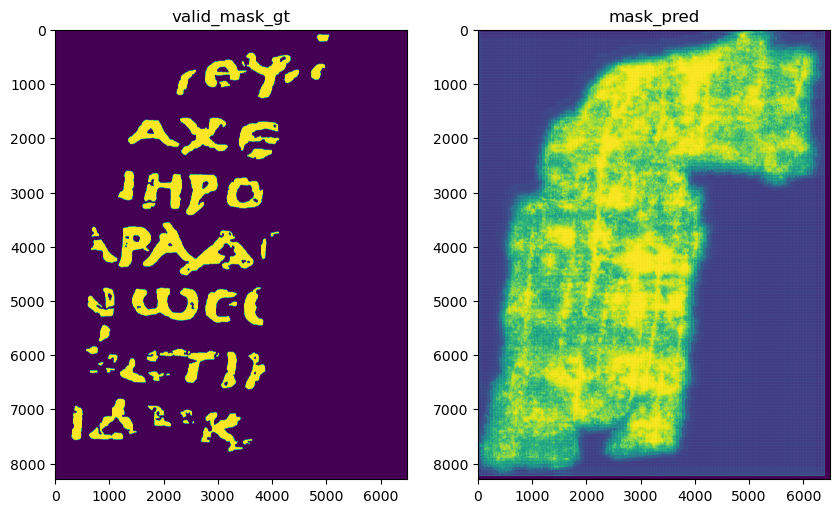

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(valid_mask_gt)
ax[1].imshow(label_pred)
ax[0].set_title('valid_mask_gt')
ax[1].set_title('mask_pred')

plt.show()


In [46]:
# scheduler_step(scheduler, avg_val_loss, epoch)
#
# best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)
#
# # score = avg_val_loss
# score = best_dice
#
# elapsed = time.time() - start_time
#
# Logger.info(
#     f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
# Logger.info(
#     f'Epoch {epoch + 1} - avgScore: {score:.4f}')
#
# if should_update_best_score(CONFIG["metric_direction"], score, best_score):
#     best_loss = avg_val_loss
#     best_score = score
#
#     Logger.info(
#         f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
#     Logger.info(
#         f'Epoch {epoch + 1} - Save Best Loss: {best_loss:.4f} Model')


In [47]:
# torch.save({'model': model.state_dict(),
#                 'best_score': best_score,
#                 'best_loss': best_loss,
#                 'pred': mask_pred},
#                get_saved_model_path(CONFIG, fold_config["valid"][0]))


In [48]:

# test_loader = make_dataset(['a','b'], dataset_mode='test')
test_loader  = make_dataset([3], dataset_mode='valid')


valid_mask_gt = test_loader.dataset.get_gt(0)

valid_mask_gt = preprocess_valid_mask_gt(valid_mask_gt, CONFIG["tile_size"])
model = build_ensemble_model()


valid_mask_gt.shape: (7606, 5249) 
valid_mask_gt.max: 255 

model_name: Unet
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpointsUnet_fold1_best.pth
model_name: Unet
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpointsUnet_fold2_best.pth
model_name: Unet
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpointsUnet_fold3_best.pth


  0%|          | 0/253 [00:00<?, ?it/s]

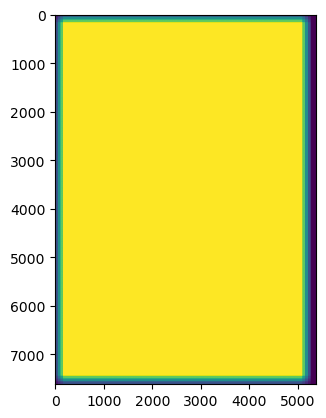

mask_count_min: 0.0


C:\Users\lzhen\miniconda3\envs\kaggle_Vesuvius\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [49]:
binary_mask=test_loader.dataset.get_mask(0)
ori_h,ori_w=binary_mask.shape

pad0 = (CONFIG["tile_size"] - binary_mask.shape[0] % CONFIG["tile_size"])
pad1 = (CONFIG["tile_size"] - binary_mask.shape[1] % CONFIG["tile_size"])

binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

label_pred = np.zeros(binary_mask.shape)
label_count = np.zeros(binary_mask.shape)

with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
    for step, (images, masks, labels, positions) in pbar:

        images = images.to(device)
        # labels = labels.to(device)
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = model(images).squeeze()
            # loss = criterion(y_preds, labels)
        # losses.update(loss.item(), batch_size)

        # make whole mask
        # y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        # start_idx = step*CONFIG["valid_batch_size"]             # end_idx = start_idx + batch_size
        # print(positions)
        for i, (x1, y1, x2, y2) in enumerate(zip(*positions)):
            label_pred[y1:y2, x1:x2] += y_preds[i]
            label_count[y1:y2, x1:x2] += np.ones((y2 - y1, x2 - x1))

plt.imshow(label_count)
plt.show()

print(f'mask_count_min: {label_count.min()}')
label_pred /= label_count

label_pred = label_pred[:ori_h, :ori_w]
binary_mask = binary_mask[:ori_h, :ori_w]
label_pred2 = (label_pred >= 0.51).astype(int)
label_pred2 *= binary_mask

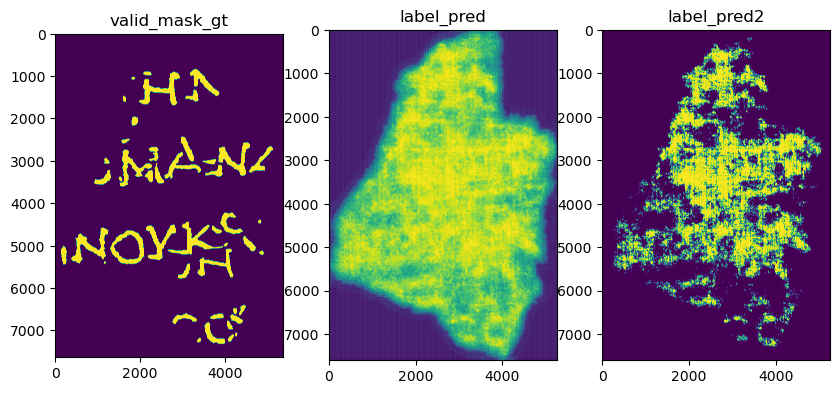

In [50]:
label_pred2 = (label_pred >= 0.9).astype(int)
label_pred2 *= binary_mask
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(valid_mask_gt)
ax[1].imshow(label_pred)
ax[2].imshow(label_pred2)
ax[0].set_title('valid_mask_gt')
ax[1].set_title('label_pred')
ax[2].set_title('label_pred2')

plt.show()


 ## submission

In [51]:
results = []


def test(fragment_id):
    model = build_ensemble_model()
    test_loader = make_dataset([fragment_id], dataset_mode='test')





In [52]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])

In [53]:
sub.Id = sub.Id.astype(str)
sub

,Id,Predicted


In [54]:
sample_sub = pd.read_csv(cfg['comp_dataset_path'] / 'sample_submission.csv')
# sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')

In [55]:
# sample_sub

In [56]:

sub.to_csv(str(OUTPUT_DIR / "submission.csv"), index=False, mode='w')